In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection  import cross_val_score, StratifiedKFold
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
def fit_clf0(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    y_pred_test = clf.predict_proba(X_test)[:,1]
    plt.figure()
    thresholds = np.linspace(0.01, 1.00, 100)
    mcc = np.array([metrics.matthews_corrcoef(y_test, y_pred_test>thr) for thr in thresholds])
    plt.plot(thresholds, mcc)
    best_threshold = thresholds[mcc.argmax()]
    print("MCC: %f" % mcc.max())
    
    return clf, best_threshold


In [3]:
X = pd.read_csv("../input/train_numeric.csv", index_col=0, nrows=100000)
X = X.loc[:, X.columns != 'Response']

In [4]:
y = pd.read_csv("../input/train_numeric.csv", index_col=0, usecols=[0,969], nrows=100000)

Idを10000で割ったときの商を特徴に入れる

In [5]:
X_index_group = pd.DataFrame(X.index).floordiv(10000).add_suffix("_group")
X_index_group['Id'] = X.index
X_index_group = X_index_group.set_index('Id')
X_move_mean = X.rolling(10000, min_periods=1000).mean().add_suffix("_move_mean")

#X2 = pd.concat([X, X_index_group, X_move_mean], axis=1)
X2 = pd.concat([X, X_index_group], axis=1)

100000行での学習→重要度ランキング

In [6]:
clf = XGBClassifier(max_depth=16, base_score=0.006)
clf.fit(X2, y['Response'])

XGBClassifier(base_score=0.006, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=16, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Text(0,0.5,'Feature Importance Score')

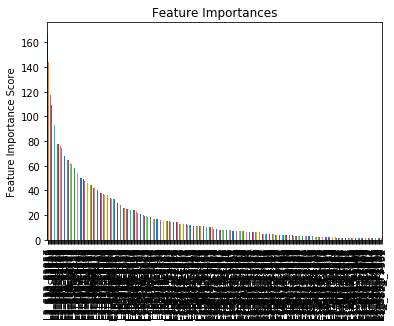

In [7]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [8]:
important_indices = np.where(clf.feature_importances_>0.005)[0]

In [12]:
important_indices

array([  0,   1,   8,   9,  10,  12,  13,  15,  17,  21,  34,  35,  37,
        40, 723, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 736,
       741, 742, 743, 744, 755, 771, 776, 780, 781, 784, 786, 788, 792,
       798, 799, 803, 818, 819, 826, 827, 828, 829, 831, 832, 836, 838,
       839, 841, 843, 848, 850, 851, 854, 864, 866, 872, 884, 885, 968],
      dtype=int64)

In [13]:
X2.columns

Index(['L0_S0_F0', 'L0_S0_F2', 'L0_S0_F4', 'L0_S0_F6', 'L0_S0_F8', 'L0_S0_F10',
       'L0_S0_F12', 'L0_S0_F14', 'L0_S0_F16', 'L0_S0_F18',
       ...
       'L3_S50_F4245', 'L3_S50_F4247', 'L3_S50_F4249', 'L3_S50_F4251',
       'L3_S50_F4253', 'L3_S51_F4256', 'L3_S51_F4258', 'L3_S51_F4260',
       'L3_S51_F4262', 'Id_group'],
      dtype='object', length=969)

重要度ランキングの高い列だけ、全行読み込む

In [14]:
X = pd.read_csv('../input/train_numeric.csv', index_col=0, usecols=np.concatenate([[0], important_indices[important_indices<968] + 1]))
y = pd.read_csv('../input/train_numeric.csv', index_col=0, usecols=[0,969])

C:\Users\tmiya\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
X_index_group = pd.DataFrame(X.index).floordiv(10000).add_suffix("_group")
X_index_group['Id'] = X.index
X_index_group = X_index_group.set_index('Id')
X_move_mean = X.rolling(10000, min_periods=1000).mean().add_suffix("_move_mean")

#X2 = pd.concat([X, X_index_group, X_move_mean], axis=1)
X2 = pd.concat([X, X_index_group], axis=1)

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.162446


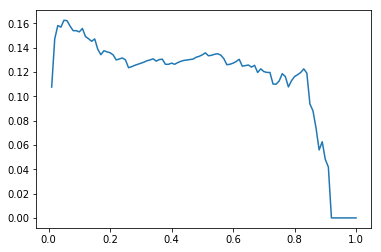

In [16]:
n = 200000
clf = XGBClassifier(max_depth=16, base_score=0.006, max_delta_step=1)
[clf, best_threshold] = fit_clf0(clf, X2[0:n:2], y[0:n:2]['Response'], X2[1:n:2], y[1:n:2]['Response'])

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.184357


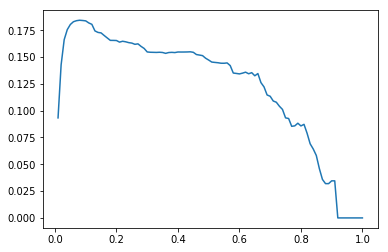

In [17]:
n = len(y)
clf = XGBClassifier(max_depth=16, base_score=0.006, max_delta_step=1)
[clf, best_threshold] = fit_clf0(clf, X2[0:n:2], y[0:n:2]['Response'], X2[1:n:2], y[1:n:2]['Response'])

max_depthをもっと深くしてみる

In [ ]:
n = 200000
clf = XGBClassifier(max_depth=30, base_score=0.006)
[clf, best_threshold] = fit_clf0(clf, X2[0:n:2], y[0:n:2]['Response'], X2[1:n:2], y[1:n:2]['Response'])

In [ ]:
n = len(y)
clf = XGBClassifier(max_depth=30, base_score=0.006, max_delta_step=1)
[clf, best_threshold] = fit_clf0(clf, X2[0:n:2], y[0:n:2]['Response'], X2[1:n:2], y[1:n:2]['Response'])

http://krasserm.github.io/2018/03/21/bayesian-optimization/
を参考にGPyOptでチューニングする

In [18]:
clf = XGBClassifier(max_depth=16, base_score=0.006, max_delta_step=1)
clf.fit(X2, y['Response'])

y_pred_test = clf.predict_proba(X_test)[:,1]
plt.figure()
thresholds = np.linspace(0.01, 1.00, 100)
mcc = np.array([metrics.matthews_corrcoef(y_test, y_pred_test>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print("MCC: %f" % mcc.max())

KeyboardInterrupt: 

C:\Users\tmiya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:538: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


MCC: 0.162446


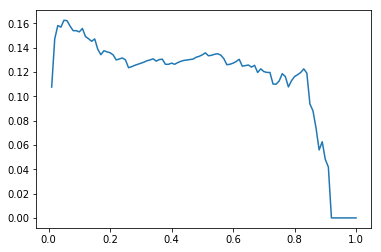

In [16]:
n = 200000
clf = XGBClassifier(max_depth=16, base_score=0.006, max_delta_step=1)
[clf, best_threshold] = fit_clf0(clf, X2[0:n:2], y[0:n:2]['Response'], X2[1:n:2], y[1:n:2]['Response'])

In [ ]:
best_threshold

In [ ]:
X_test = pd.read_csv('../input/test_numeric.csv', index_col=0, usecols=np.concatenate([[0], important_indices + 1]))

In [ ]:
X_index_group = pd.DataFrame(X_test.index).floordiv(10000).add_suffix("_group")
X_index_group['Id'] = X_test.index
X_index_group = X_index_group.set_index('Id')
X_move_mean = X_test.rolling(10000, min_periods=1000).mean().add_suffix("_move_mean")

#X2 = pd.concat([X, X_index_group, X_move_mean], axis=1)
X_test2 = pd.concat([X_test, X_index_group], axis=1)

In [ ]:
preds = (clf.predict_proba(X_test2)[:,1] > best_threshold).astype(np.int8)
sub = pd.read_csv("../input/sample_submission.csv", index_col=0)
sub["Response"] = preds
sub.to_csv("submission.csv.gz", compression="gzip")